<a href="https://colab.research.google.com/github/pannavich/rpi-pythoncode/blob/master/gesture_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library and download dataset

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,multilabel_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!gdown https://drive.google.com/uc?id=1D_WgUtyXj5t8qXinLyXtkri02zWWumx_ -O /content/dataset.zip



Downloading...
From: https://drive.google.com/uc?id=1D_WgUtyXj5t8qXinLyXtkri02zWWumx_
To: /content/dataset.zip
100% 116k/116k [00:00<00:00, 48.0MB/s]


In [ ]:
os.mkdir('/content/dataset/')
!unzip "/content/dataset.zip" -d "/content/dataset/"

Archive:  /content/dataset.zip
  inflating: /content/dataset/raw_air_motor_on.npy  
  inflating: /content/dataset/raw_air_off.npy  
  inflating: /content/dataset/raw_air_on.npy  
  inflating: /content/dataset/raw_buzzer_off.npy  
  inflating: /content/dataset/raw_motor_off.npy  
  inflating: /content/dataset/raw_motor_on.npy  


Downloading...
From: https://drive.google.com/uc?id=1k26noxjb2_dzO0Z8A0TdrE-wznGrw4Bx
To: /content/img.jpg
100% 139k/139k [00:00<00:00, 51.5MB/s]


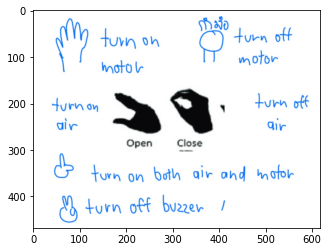

In [ ]:
!gdown -O /content/img.jpg https://drive.google.com/uc?id=1k26noxjb2_dzO0Z8A0TdrE-wznGrw4Bx
img = plt.imread('/content/img.jpg')
plt.imshow(img)

# Data preparation

In [ ]:

actions = ['motor_on','motor_off','air_on','air_off','air_motor_on','buzzer_off']


data = np.concatenate([
    np.load('/content/dataset/raw_motor_on.npy',allow_pickle=True),
    np.load('/content/dataset/raw_motor_off.npy',allow_pickle=True),
    np.load('/content/dataset/raw_air_on.npy',allow_pickle=True),
    np.load('/content/dataset/raw_air_off.npy',allow_pickle=True),
    np.load('/content/dataset/raw_air_motor_on.npy',allow_pickle=True),
    np.load('/content/dataset/raw_buzzer_off.npy',allow_pickle=True)

], axis=0)



In [ ]:
print(data[-1][1])
print(data.shape)


5
(300, 2)


In [ ]:
X = []
y = []
for idx,i in enumerate(data[:,0]):
  if(i is not None):
    X.append(np.array(i[:-1]))
    y.append(data[idx,1])
X = np.array(X)

y = np.array(y)
y = to_categorical(y,num_classes=6)

print(X.shape,y.shape)


(300, 99) (300, 6)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)

# LSTM Model

In [ ]:
model = Sequential()

model.add(LSTM(64, activation='relu', input_shape=(99,1)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['acc'])
#activation sigmoid

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 21,446
Trainable params: 21,446
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 16
epochs = 40
earlystopper = EarlyStopping(monitor='val_acc',mode='max',patience=4,min_delta=0.04)
history = model.fit(X_train, y_train, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    epochs = epochs,
                    shuffle=True, 
                    callbacks = [earlystopper],
                    verbose = 1
            )

Epoch 1/40
13/13 [==============================] - 7s 332ms/step - loss: 4.6939 - acc: 0.2537 - val_loss: 1.5810 - val_acc: 0.3939
Epoch 2/40
13/13 [==============================] - 4s 293ms/step - loss: 2.0286 - acc: 0.4478 - val_loss: 1.0414 - val_acc: 0.5354
Epoch 3/40
13/13 [==============================] - 4s 282ms/step - loss: 1.3377 - acc: 0.5174 - val_loss: 0.7077 - val_acc: 0.7172
Epoch 4/40
13/13 [==============================] - 4s 300ms/step - loss: 1.0084 - acc: 0.6716 - val_loss: 0.5974 - val_acc: 0.9192
Epoch 5/40
13/13 [==============================] - 4s 302ms/step - loss: 0.7652 - acc: 0.7811 - val_loss: 0.5159 - val_acc: 0.9192
Epoch 6/40
13/13 [==============================] - 4s 297ms/step - loss: 0.6072 - acc: 0.8060 - val_loss: 0.4247 - val_acc: 0.9293
Epoch 7/40
13/13 [==============================] - 4s 300ms/step - loss: 0.3094 - acc: 0.8905 - val_loss: 0.2245 - val_acc: 0.9495
Epoch 8/40
13/13 [==============================] - 4s 296ms/step - loss: 0.

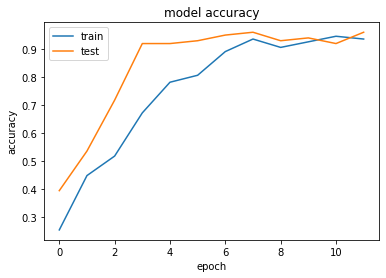

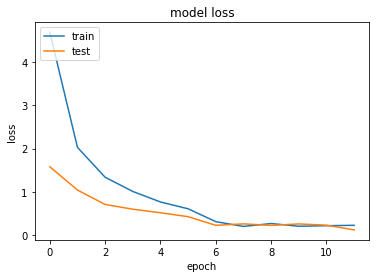

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = []
prediction = model.predict(X_test)
for i in prediction:
  y_pred.append(int(np.argmax(i)))
y_pred = np.array(y_pred)
eval_df = pd.DataFrame()
eval_df['y_actual'] = [np.argmax(i) for i in y_test[:]]
eval_df['y_pred'] = y_pred

In [ ]:
confusion =  confusion_matrix(eval_df['y_actual'], eval_df['y_pred'], labels=[0,1,2,3,4,5])
print('Confusion Matrix\n')
print(confusion)

multi_confusion =  multilabel_confusion_matrix(eval_df['y_actual'], eval_df['y_pred'], labels=[0,1,2,3,4,5])
print('Multilabel Confusion Matrix\n')
print(multi_confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(eval_df['y_actual'], eval_df['y_pred'])))

print('Micro Precision: {:.2f}'.format(precision_score(eval_df['y_actual'], eval_df['y_pred'], average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(eval_df['y_actual'], eval_df['y_pred'], average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(eval_df['y_actual'], eval_df['y_pred'], average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(eval_df['y_actual'], eval_df['y_pred'], average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(eval_df['y_actual'], eval_df['y_pred'], average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(eval_df['y_actual'], eval_df['y_pred'], average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(eval_df['y_actual'], eval_df['y_pred'], average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(eval_df['y_actual'], eval_df['y_pred'], average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(eval_df['y_actual'], eval_df['y_pred'], average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(eval_df['y_actual'], eval_df['y_pred'], target_names=['motor_on','motor_off','air_on','air_off','air_motor_on','buzzer_off']))

Confusion Matrix

[[18  0  0  0  0  0]
 [ 0 18  0  0  2  0]
 [ 0  0 13  2  0  0]
 [ 0  0  0 17  0  0]
 [ 0  0  0  0 17  0]
 [ 0  0  0  0  0 12]]
Multilabel Confusion Matrix

[[[81  0]
  [ 0 18]]

 [[79  0]
  [ 2 18]]

 [[84  0]
  [ 2 13]]

 [[80  2]
  [ 0 17]]

 [[80  2]
  [ 0 17]]

 [[87  0]
  [ 0 12]]]

Accuracy: 0.96

Micro Precision: 0.96
Micro Recall: 0.96
Micro F1-score: 0.96

Macro Precision: 0.96
Macro Recall: 0.96
Macro F1-score: 0.96

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1-score: 0.96

Classification Report

              precision    recall  f1-score   support

    motor_on       1.00      1.00      1.00        18
   motor_off       1.00      0.90      0.95        20
      air_on       1.00      0.87      0.93        15
     air_off       0.89      1.00      0.94        17
air_motor_on       0.89      1.00      0.94        17
  buzzer_off       1.00      1.00      1.00        12

    accuracy                           0.96        99
   macro avg       0.9

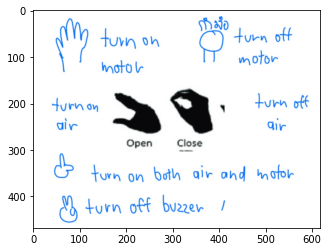

In [ ]:
plt.imshow(img)

Confusion Matrix



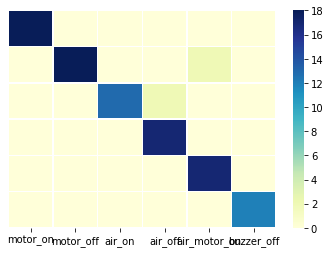

In [ ]:
print('Confusion Matrix\n')
ax = sns.heatmap(confusion,linewidths=.5,cmap="YlGnBu",yticklabels=False)
ax.set_xticklabels(actions) 
plt.show()

# Random forest model

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)



RandomForestClassifier()

In [ ]:
y_pred = []
prediction = clf.predict(X_test)
for i in prediction:
  y_pred.append(int(np.argmax(i)))
y_pred = np.array(y_pred)
eval_df = pd.DataFrame()
eval_df['y_actual'] = [np.argmax(i) for i in y_test[:]]
eval_df['y_pred'] = y_pred

In [ ]:
confusion =  confusion_matrix(eval_df['y_actual'], eval_df['y_pred'], labels=[0,1,2,3,4,5])
print('Confusion Matrix\n')
print(confusion)

multi_confusion =  multilabel_confusion_matrix(eval_df['y_actual'], eval_df['y_pred'], labels=[0,1,2,3,4,5])
print('Multilabel Confusion Matrix\n')
print(multi_confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(eval_df['y_actual'], eval_df['y_pred'])))

print('Micro Precision: {:.2f}'.format(precision_score(eval_df['y_actual'], eval_df['y_pred'], average='micro',zero_division=0)))
print('Micro Recall: {:.2f}'.format(recall_score(eval_df['y_actual'], eval_df['y_pred'], average='micro',zero_division=0)))
print('Micro F1-score: {:.2f}\n'.format(f1_score(eval_df['y_actual'], eval_df['y_pred'], average='micro',zero_division=0)))

print('Macro Precision: {:.2f}'.format(precision_score(eval_df['y_actual'], eval_df['y_pred'], average='macro',zero_division=0)))
print('Macro Recall: {:.2f}'.format(recall_score(eval_df['y_actual'], eval_df['y_pred'], average='macro',zero_division=0)))
print('Macro F1-score: {:.2f}\n'.format(f1_score(eval_df['y_actual'], eval_df['y_pred'], average='macro',zero_division=0)))

print('Weighted Precision: {:.2f}'.format(precision_score(eval_df['y_actual'], eval_df['y_pred'], average='weighted',zero_division=0)))
print('Weighted Recall: {:.2f}'.format(recall_score(eval_df['y_actual'], eval_df['y_pred'], average='weighted',zero_division=0)))
print('Weighted F1-score: {:.2f}'.format(f1_score(eval_df['y_actual'], eval_df['y_pred'], average='weighted',zero_division=0)))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(eval_df['y_actual'], eval_df['y_pred'], target_names=['motor_on','motor_off','air_on','air_off','air_motor_on','buzzer_off'],zero_division=0))

Confusion Matrix

[[18  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 15  0  0  0]
 [ 0  0  2 15  0  0]
 [ 0  0  0  0 17  0]
 [ 0  0  0  0  0 12]]
Multilabel Confusion Matrix

[[[81  0]
  [ 0 18]]

 [[79  0]
  [ 0 20]]

 [[82  2]
  [ 0 15]]

 [[82  0]
  [ 2 15]]

 [[82  0]
  [ 0 17]]

 [[87  0]
  [ 0 12]]]

Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.98
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

    motor_on       1.00      1.00      1.00        18
   motor_off       1.00      1.00      1.00        20
      air_on       0.88      1.00      0.94        15
     air_off       1.00      0.88      0.94        17
air_motor_on       1.00      1.00      1.00        17
  buzzer_off       1.00      1.00      1.00        12

    accuracy                           0.98        99
   macro avg       0.9

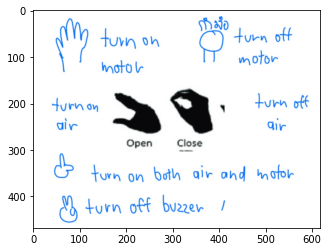

In [ ]:
plt.imshow(img)

Confusion Matrix



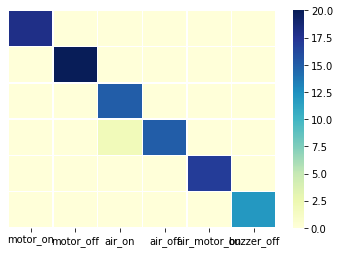

In [ ]:
print('Confusion Matrix\n')
ax = sns.heatmap(confusion,linewidths=.5,cmap="YlGnBu",yticklabels=False)
ax.set_xticklabels(actions) 
plt.show()

# Saving model


In [ ]:
save_path = os.path.join("/content/", "model")
tf.saved_model.save(model, save_path)